<a href="https://colab.research.google.com/github/venom1204/symbolic/blob/main/task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sympy numpy pandas matplotlib seaborn tqdm


In [ ]:
import sympy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import json
from google.colab import drive
import os
from tqdm.notebook import tqdm
from collections import Counter

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')
base_dir = '/content/drive/MyDrive/GSoC_Symbolic_Calculation'
os.makedirs(base_dir, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')
base_dir = '/content/drive/MyDrive/GSoC_Symbolic_Calculation'
os.makedirs(base_dir, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print("Step 1: Defining functions and generating dataset...")

# Define symbol and functions
x = sp.symbols('x')

# Create a diverse set of functions that work well with Taylor expansions
basic_functions = [
    ('sin(x)', sp.sin(x)),
    ('cos(x)', sp.cos(x)),
    ('exp(x)', sp.exp(x)),
    ('log(1+x)', sp.log(1+x)),
    ('tan(x)', sp.tan(x)),
    ('sinh(x)', sp.sinh(x)),
    ('tanh(x)', sp.tanh(x)),
    ('arctan(x)', sp.atan(x)),
    ('arcsinh(x)', sp.asinh(x)),
    ('arctanh(x/2)', sp.atanh(x/2)),  # Domain restriction to ensure |x/2| < 1
    ('1/(1+x)', 1/(1+x)),
    ('sqrt(1+x)', sp.sqrt(1+x)),
    ('x^2', x**2),
    ('x^3', x**3),
    ('x^4', x**4),
]

# Visualize basic functions
print("\nBasic functions defined:")
for name, func in basic_functions:
    print(f"- {name}: {func}")

# Function to check if a composition will be valid for Taylor expansion
def is_valid_composition(func_name, func):
    try:
        # Check for common invalid patterns
        if ('arcsin' in func_name and any(f in func_name for f in ['cosh', 'exp'])) or \
           ('arccos' in func_name and any(f in func_name for f in ['cosh', 'exp'])):
            return False

        # Try to evaluate at x=0 to check domain
        value_at_zero = func.subs(x, 0)
        if value_at_zero.is_real == False or value_at_zero is sp.nan:
            return False

        # Try to compute a simple derivative to check for domain issues
        derivative = sp.diff(func, x)
        derivative_at_zero = derivative.subs(x, 0)
        if derivative_at_zero.is_real == False or derivative_at_zero is sp.nan:
            return False

        # IMPROVED VALIDATION: Check higher-order derivatives
        for i in range(2, 5):
            higher_deriv = sp.diff(func, x, i)
            higher_deriv_at_zero = higher_deriv.subs(x, 0)
            if higher_deriv_at_zero.is_real == False or higher_deriv_at_zero is sp.nan:
                return False

        # Try to compute a simple series term
        series_term = sp.series(func, x, 0, 2)

        # IMPROVED VALIDATION: Check if series is convergent near x=0
        # by evaluating at a small value
        try:
            small_x_value = 0.01
            func_value = func.subs(x, small_x_value)
            if func_value.is_real == False or func_value is sp.nan:
                return False
        except:
            return False

        return True
    except Exception as e:
        return False

Step 1: Defining functions and generating dataset...

Basic functions defined:
- sin(x): sin(x)
- cos(x): cos(x)
- exp(x): exp(x)
- log(1+x): log(x + 1)
- tan(x): tan(x)
- sinh(x): sinh(x)
- tanh(x): tanh(x)
- arctan(x): atan(x)
- arcsinh(x): asinh(x)
- arctanh(x/2): atanh(x/2)
- 1/(1+x): 1/(x + 1)
- sqrt(1+x): sqrt(x + 1)
- x^2: x**2
- x^3: x**3
- x^4: x**4


In [ ]:
print("\nStep 2: Generating composite functions...")

# Generate composite functions with validation
composite_functions = []
valid_count = 0
invalid_count = 0
attempts = 0

# Progress bar for composite function generation
pbar = tqdm(total=50, desc="Generating composite functions")

while len(composite_functions) < 50 and attempts < 500:  # Increased max attempts
    attempts += 1
    # Randomly select 2-3 functions to compose
    funcs = random.sample(basic_functions, random.randint(2, 3))
    composed = funcs[0][1]
    name = funcs[0][0]

    valid = True
    composition_attempt = name
    for fname, f in funcs[1:]:
        try:
            new_composed = composed.subs(x, f)
            new_name = name.replace('x', f'({fname})')
            composition_attempt = new_name

            if not is_valid_composition(new_name, new_composed):
                valid = False
                invalid_count += 1
                # Print some invalid compositions for debugging
                if invalid_count % 20 == 0:
                    print(f"  Invalid composition rejected: {new_name}")
                break

            composed = new_composed
            name = new_name
        except Exception as e:
            valid = False
            invalid_count += 1
            if invalid_count % 20 == 0:
                print(f"  Error in composition {composition_attempt}: {e}")
            break

    if valid:
        composite_functions.append((name, composed))
        valid_count += 1
        pbar.update(1)

pbar.close()
print(f"Generated {len(composite_functions)} valid composite functions")
print(f"Rejected {invalid_count} invalid compositions")
print(f"Acceptance rate: {valid_count/(valid_count+invalid_count)*100:.2f}%")

# Visualize a few composite functions
print("\nSample composite functions:")
for i, (name, func) in enumerate(composite_functions[:5]):
    print(f"- {name}: {func}")


Step 2: Generating composite functions...


Generating composite functions:   0%|          | 0/50 [00:00<?, ?it/s]

Generated 50 valid composite functions
Rejected 1 invalid compositions
Acceptance rate: 98.04%

Sample composite functions:
- (arctanh(x/2))^3: atanh(x/2)**3
- tan(((1/(1+x))^3)): tan((x + 1)**(-3))
- 1/(1+(x^4)): 1/(x**4 + 1)
- (tan((cos(x))))^3: tan(cos(x))**3
- (sin((arctan(x))))^3: x**3/(x**2 + 1)**(3/2)


In [ ]:
print("\nStep 3: Generating polynomial functions...")

# IMPROVED: Generate more polynomial functions for a larger dataset
polynomial_functions = []
for i in range(100):  # Increased from 30 to 100
    degree = random.randint(2, 8)  # Increased max degree
    coeffs = [random.randint(-10, 10) for _ in range(degree+1)]
    # Ensure at least one coefficient is non-zero
    if all(c == 0 for c in coeffs):
        coeffs[0] = 1

    poly = sum(c*x**i for i, c in enumerate(coeffs))
    name = f"polynomial_{i}"
    polynomial_functions.append((name, poly))

# Visualize a few polynomial functions
print("\nSample polynomial functions:")
for i, (name, func) in enumerate(polynomial_functions[:5]):
    print(f"- {name}: {func}")



Step 3: Generating polynomial functions...

Sample polynomial functions:
- polynomial_0: -9*x**6 - 7*x**5 + 7*x**4 - 5*x**3 - x**2 + 3*x + 6
- polynomial_1: 4*x**7 - 4*x**6 - 6*x**5 + 10*x**4 + 6*x**3 + 2*x**2 + x + 1
- polynomial_2: 3*x**7 - 5*x**6 - 9*x**5 - 3*x**4 + 8*x**3 + 10*x**2 + 5*x - 5
- polynomial_3: -3*x**5 - 5*x**4 + 10*x**3 + 7*x**2 - 5*x - 3
- polynomial_4: -9*x**5 - 7*x**4 + 6*x**3 - 3*x**2 + x - 7


In [ ]:
print("\nStep 4: Generating rational functions...")

# IMPROVED: Generate more rational functions for a larger dataset
rational_functions = []
for i in range(50):  # Increased from 20 to 50
    num_degree = random.randint(1, 5)  # Increased max degree
    den_degree = random.randint(1, 4)  # Increased max degree

    num_coeffs = [random.randint(-8, 8) for _ in range(num_degree+1)]
    den_coeffs = [random.randint(-8, 8) for _ in range(den_degree+1)]

    # Ensure numerator has at least one non-zero coefficient
    if all(c == 0 for c in num_coeffs):
        num_coeffs[0] = 1

    # Ensure denominator is not zero at x=0
    if den_coeffs[0] == 0:
        den_coeffs[0] = random.choice([-1, 1])

    numerator = sum(c*x**i for i, c in enumerate(num_coeffs))
    denominator = sum(c*x**i for i, c in enumerate(den_coeffs))

    rational = numerator / denominator
    name = f"rational_{i}"
    rational_functions.append((name, rational))

# Visualize a few rational functions
print("\nSample rational functions:")
for i, (name, func) in enumerate(rational_functions[:5]):
    print(f"- {name}: {func}")

# Combine all functions
all_functions = basic_functions + composite_functions + polynomial_functions + rational_functions
print(f"\nTotal functions generated: {len(all_functions)}")



Step 4: Generating rational functions...

Sample rational functions:
- rational_0: (x**3 - x**2 - 7*x + 6)/(6*x**2 + 1)
- rational_1: (-3*x**3 - 2*x**2 + 5*x)/(5*x**4 - 3*x**3 + 4*x + 8)
- rational_2: (6*x**4 + 4*x**3 - 3*x**2 - x + 8)/(-2*x**2 - 2*x + 4)
- rational_3: (-7*x**5 + 3*x**4 - 7*x**3 + 2*x**2 + 5*x - 7)/(-2*x - 7)
- rational_4: (1 - 3*x)/(7*x - 4)

Total functions generated: 215


In [ ]:
# IMPROVED: Add function variations to increase dataset size
print("\nStep 4.5: Generating function variations...")

function_variations = []
for name, func in random.sample(all_functions, min(100, len(all_functions))):
    # Scale the input
    for scale in [0.5, 2, 3]:
        new_func = func.subs(x, scale*x)
        new_name = f"{name}_scaled_{scale}"
        function_variations.append((new_name, new_func))

    # Add a constant
    for const in [-2, -1, 1, 2]:
        new_func = func + const
        new_name = f"{name}_plus_{const}"
        function_variations.append((new_name, new_func))

    # Combine with simple polynomial
    for power in [1, 2]:
        new_func = func + x**power
        new_name = f"{name}_plus_x^{power}"
        function_variations.append((new_name, new_func))

all_functions.extend(function_variations)
print(f"Added {len(function_variations)} function variations")
print(f"New total: {len(all_functions)} functions")



Step 4.5: Generating function variations...
Added 900 function variations
New total: 1115 functions


In [ ]:
print("\nStep 5: Computing Taylor expansions...")

# Compute Taylor expansions with robust error handling
data = []
success_count = 0
failure_count = 0
alternative_method_count = 0

# Progress bar for Taylor expansion computation
pbar = tqdm(total=len(all_functions), desc="Computing Taylor expansions")

for idx, (name, func) in enumerate(all_functions):
    pbar.update(1)

    try:
        # Compute Taylor expansion up to 4th order
        taylor = sp.series(func, x, 0, 5).removeO()

        # Store function, expansion, and symbolic forms
        func_str = str(func)
        taylor_str = str(taylor)

        # Store pretty-printed versions for visualization
        func_pretty = sp.pretty(func)
        taylor_pretty = sp.pretty(taylor)

        data.append({
            'name': name,
            'function': func_str,
            'taylor': taylor_str,
            'function_pretty': func_pretty,
            'taylor_pretty': taylor_pretty
        })
        success_count += 1
    except Exception as e:
        # Try a different approach for problematic functions
        try:
            # Try computing term by term
            taylor_terms = []
            for i in range(5):
                term = sp.diff(func, x, i).subs(x, 0) * x**i / sp.factorial(i)
                taylor_terms.append(term)

            taylor = sum(taylor_terms)

            # Store function, expansion, and symbolic forms
            func_str = str(func)
            taylor_str = str(taylor)

            # Store pretty-printed versions for visualization
            func_pretty = sp.pretty(func)
            taylor_pretty = sp.pretty(taylor)

            data.append({
                'name': name,
                'function': func_str,
                'taylor': taylor_str,
                'function_pretty': func_pretty,
                'taylor_pretty': taylor_pretty
            })
            alternative_method_count += 1
        except Exception as e2:
            failure_count += 1

pbar.close()
print(f"\nTaylor expansion statistics:")
print(f"- Successfully processed (standard method): {success_count}")
print(f"- Successfully processed (alternative method): {alternative_method_count}")
print(f"- Failed to process: {failure_count}")
print(f"- Total successful: {success_count + alternative_method_count} out of {len(all_functions)}")

# Create DataFrame
df = pd.DataFrame(data)
print(f"\nDataFrame created with {len(df)} rows")



Step 5: Computing Taylor expansions...


Computing Taylor expansions:   0%|          | 0/1115 [00:00<?, ?it/s]


Taylor expansion statistics:
- Successfully processed (standard method): 1114
- Successfully processed (alternative method): 1
- Failed to process: 0
- Total successful: 1115 out of 1115

DataFrame created with 1115 rows


In [ ]:
print("\nStep 6: Tokenizing expressions...")

# IMPROVED: Normalize expressions before tokenization
def normalize_expression(expr):
    # Convert ** to ^ for consistency
    expr = expr.replace('**', '^')
    # Ensure spaces around operators
    expr = re.sub(r'([+\-*/^()])', r' \1 ', expr)
    # Collapse multiple spaces
    expr = re.sub(r'\s+', ' ', expr).strip()
    return expr

# Advanced tokenization function
def tokenize(expr):
    # Normalize the expression first
    expr = normalize_expression(expr)

    # Split by whitespace and filter empty tokens
    tokens = [token for token in expr.split() if token]

    # Handle numbers and variables separately
    processed_tokens = []
    for token in tokens:
        if token in ['+', '-', '*', '/', '^', '(', ')']:
            processed_tokens.append(token)
        elif token.replace('.', '', 1).isdigit() or (token.startswith('-') and token[1:].replace('.', '', 1).isdigit()):
            # It's a number (including negative numbers)
            processed_tokens.append('NUM_' + token)
        else:
            # It's a function or variable
            processed_tokens.append(token)

    return processed_tokens

# Test tokenization on a sample expression
sample_expr = "sin(x) + 3*x^2 - 5/x"
sample_expr2 = "sin(x) + 3*x**2 - 5/x"  # Alternative notation
sample_tokens = tokenize(sample_expr)
sample_tokens2 = tokenize(sample_expr2)
print("\nTokenization example:")
print(f"Original 1: {sample_expr}")
print(f"Tokenized 1: {sample_tokens}")
print(f"Original 2: {sample_expr2}")
print(f"Tokenized 2: {sample_tokens2}")
print(f"Tokens match: {sample_tokens == sample_tokens2}")

# Apply tokenization to the dataframe
df['function_tokens'] = df['function'].apply(tokenize)
df['taylor_tokens'] = df['taylor'].apply(tokenize)
print("\nTokenization applied to all expressions")

# IMPROVED: Analyze sequence lengths
function_token_lengths = [len(tokens) for tokens in df['function_tokens']]
taylor_token_lengths = [len(tokens) for tokens in df['taylor_tokens']]

print("\nSequence length statistics:")
print(f"Function tokens - Min: {min(function_token_lengths)}, Max: {max(function_token_lengths)}, Mean: {np.mean(function_token_lengths):.2f}")
print(f"Taylor tokens - Min: {min(taylor_token_lengths)}, Max: {max(taylor_token_lengths)}, Mean: {np.mean(taylor_token_lengths):.2f}")


Step 6: Tokenizing expressions...

Tokenization example:
Original 1: sin(x) + 3*x^2 - 5/x
Tokenized 1: ['sin', '(', 'x', ')', '+', 'NUM_3', '*', 'x', '^', 'NUM_2', '-', 'NUM_5', '/', 'x']
Original 2: sin(x) + 3*x**2 - 5/x
Tokenized 2: ['sin', '(', 'x', ')', '+', 'NUM_3', '*', 'x', '^', 'NUM_2', '-', 'NUM_5', '/', 'x']
Tokens match: True

Tokenization applied to all expressions

Sequence length statistics:
Function tokens - Min: 1, Max: 58, Mean: 24.16
Taylor tokens - Min: 1, Max: 638, Mean: 28.69



Step 7: Visualizing the dataset...


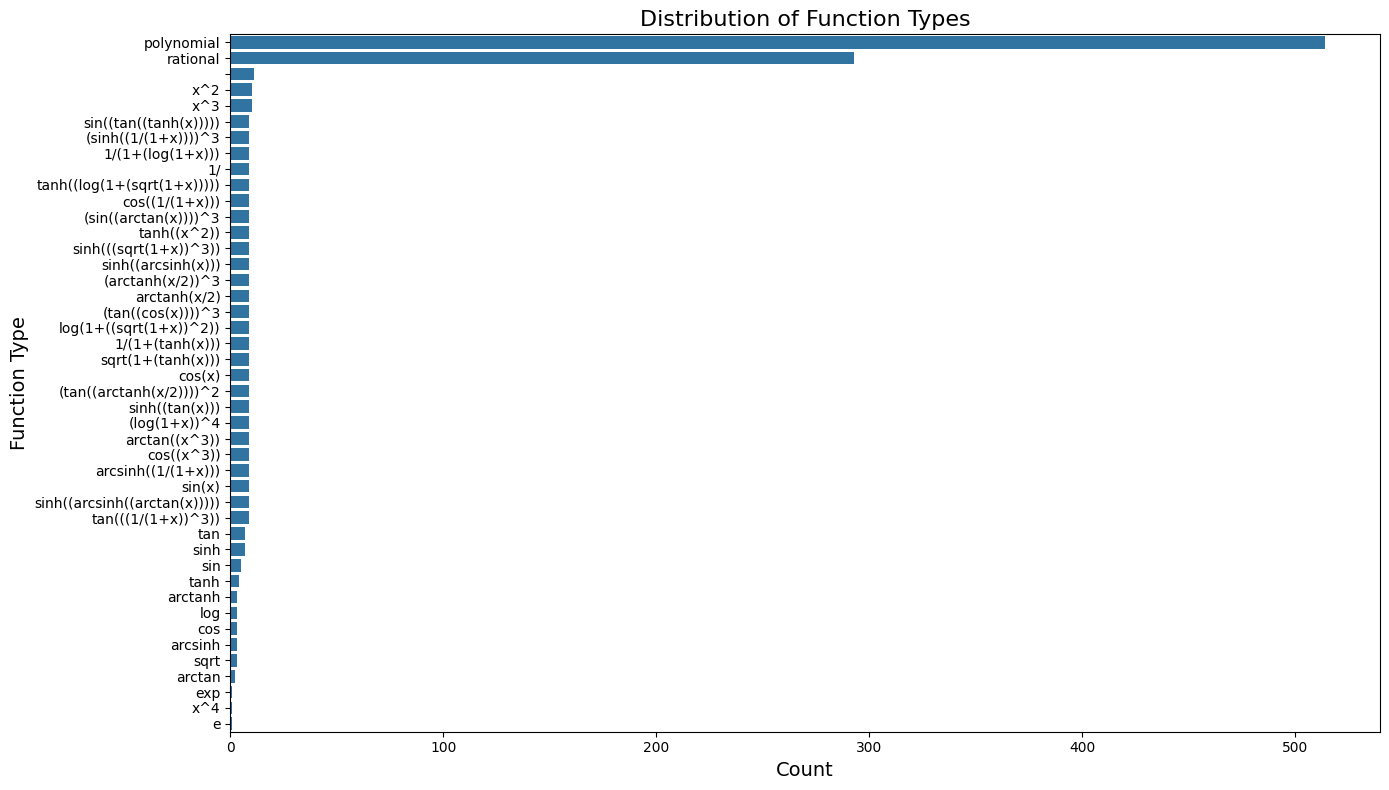

In [ ]:
print("\nStep 7: Visualizing the dataset...")

# Visualize the dataset
plt.figure(figsize=(14, 8))
function_types = df['name'].apply(lambda x: x.split('_')[0] if '_' in x else x.split('(')[0])
type_counts = function_types.value_counts()
sns.barplot(x=type_counts.values, y=type_counts.index)
plt.title('Distribution of Function Types', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Function Type', fontsize=14)
plt.tight_layout()
plt.savefig(f'{base_dir}/function_distribution.png')
plt.show()

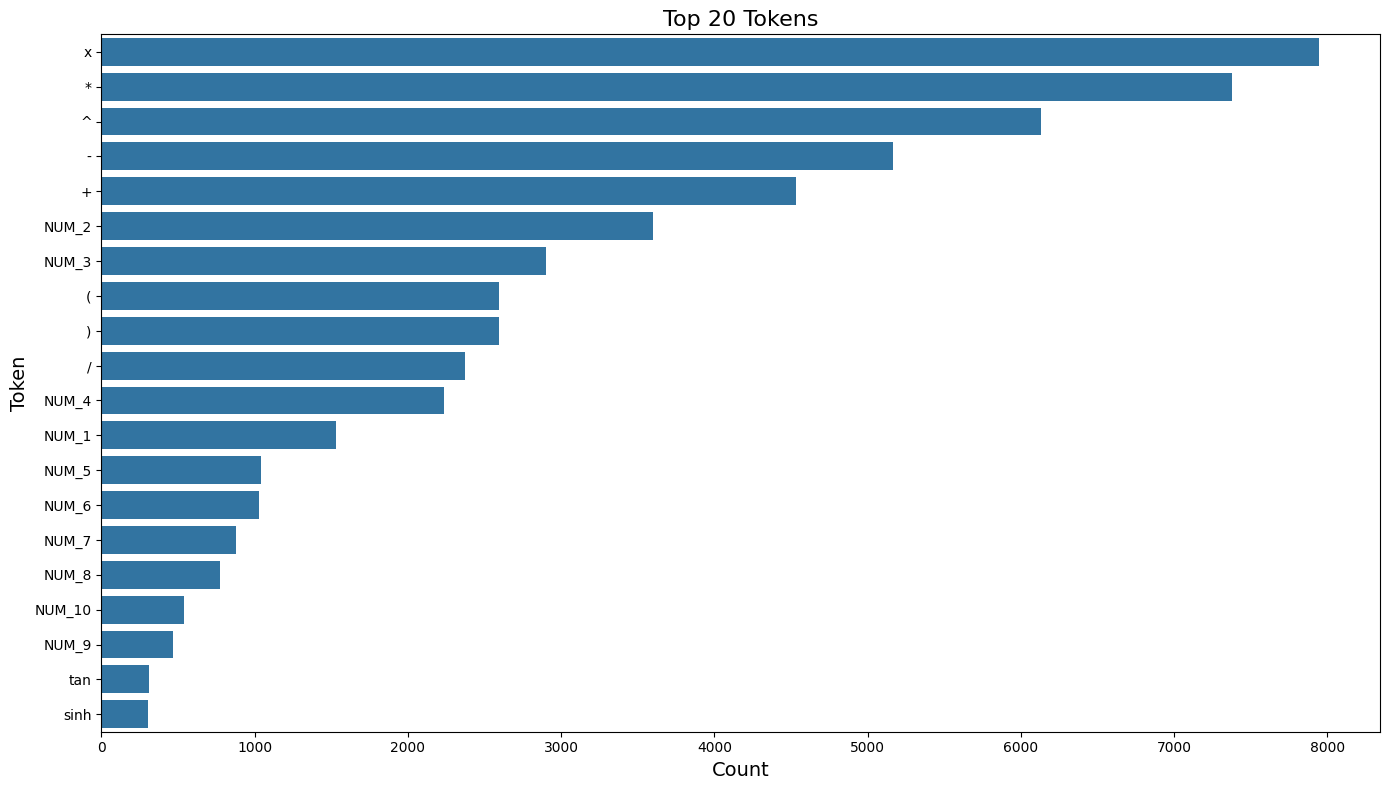

In [ ]:
# Visualize token distribution
all_tokens = []
for tokens in df['function_tokens'] + df['taylor_tokens']:
    all_tokens.extend(tokens)

token_counts = pd.Series(all_tokens).value_counts().head(20)
plt.figure(figsize=(14, 8))
sns.barplot(x=token_counts.values, y=token_counts.index)
plt.title('Top 20 Tokens', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Token', fontsize=14)
plt.tight_layout()
plt.savefig(f'{base_dir}/token_distribution.png')
plt.show()

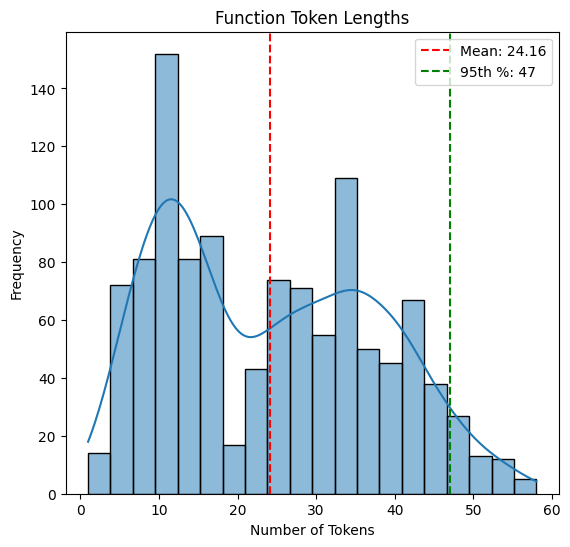

In [ ]:
# IMPROVED: Visualize sequence length distributions
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(function_token_lengths, bins=20, kde=True)
plt.axvline(x=np.mean(function_token_lengths), color='r', linestyle='--', label=f'Mean: {np.mean(function_token_lengths):.2f}')
plt.axvline(x=np.percentile(function_token_lengths, 95), color='g', linestyle='--', label=f'95th %: {np.percentile(function_token_lengths, 95):.0f}')
plt.title('Function Token Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()


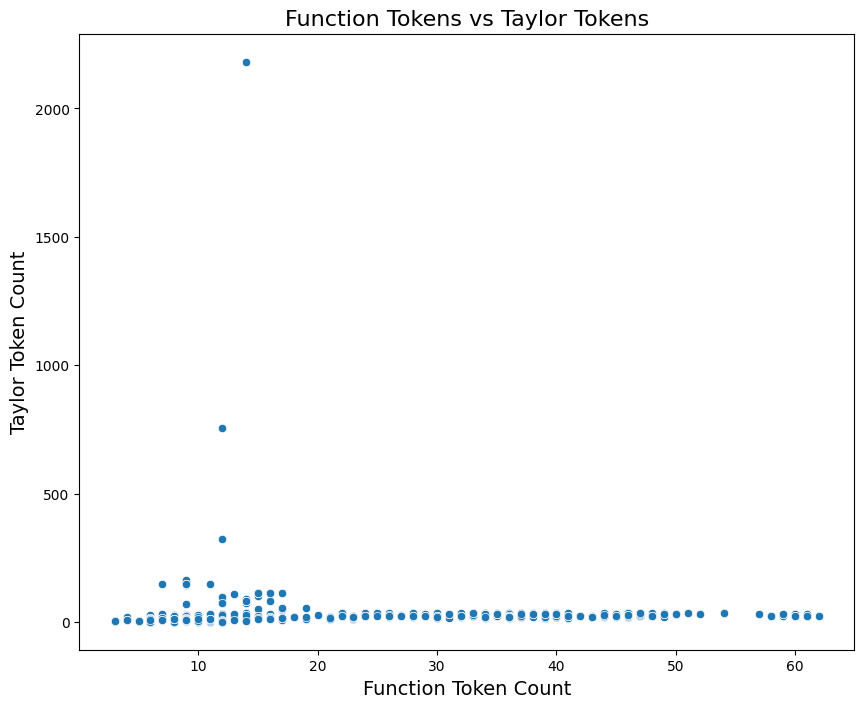

In [ ]:
# Visualize relationship between function and taylor token lengths
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=function_token_lengths,
    y=taylor_token_lengths
)
plt.title('Function Tokens vs Taylor Tokens', fontsize=16)
plt.xlabel('Function Token Count', fontsize=14)
plt.ylabel('Taylor Token Count', fontsize=14)
plt.savefig(f'{base_dir}/token_count_relationship.png')
plt.show()

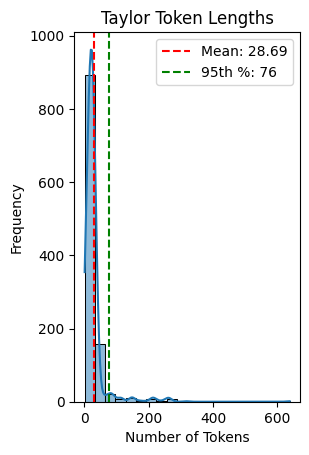

In [ ]:
plt.subplot(1, 2, 2)
sns.histplot(taylor_token_lengths, bins=20, kde=True)
plt.axvline(x=np.mean(taylor_token_lengths), color='r', linestyle='--', label=f'Mean: {np.mean(taylor_token_lengths):.2f}')
plt.axvline(x=np.percentile(taylor_token_lengths, 95), color='g', linestyle='--', label=f'95th %: {np.percentile(taylor_token_lengths, 95):.0f}')
plt.title('Taylor Token Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()


In [ ]:
plt.tight_layout()
plt.savefig(f'{base_dir}/token_length_distributions.png')
plt.show()

<Figure size 640x480 with 0 Axes>

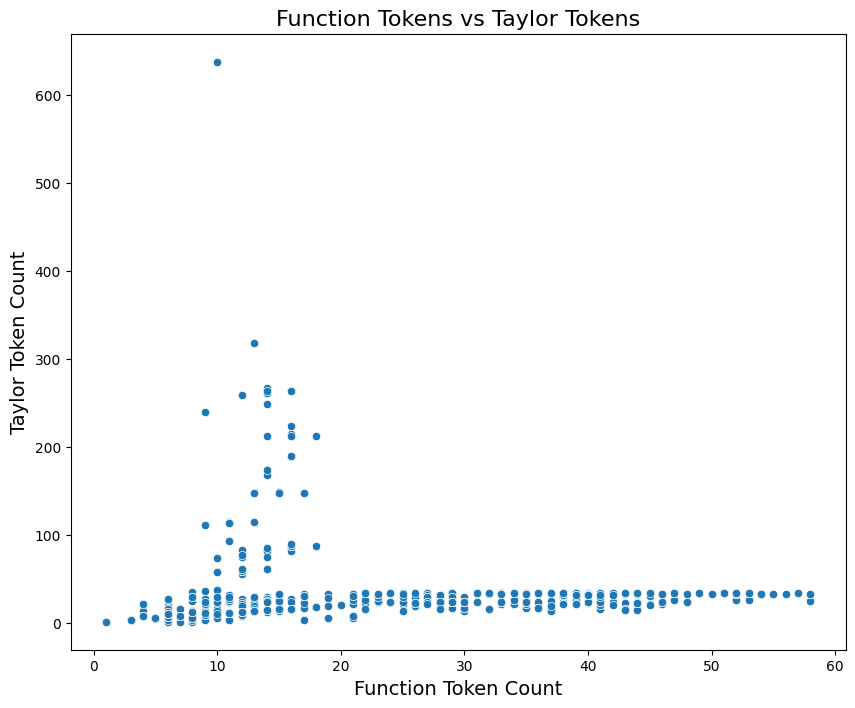

In [ ]:
# Visualize relationship between function and taylor token lengths
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=function_token_lengths,
    y=taylor_token_lengths
)
plt.title('Function Tokens vs Taylor Tokens', fontsize=16)
plt.xlabel('Function Token Count', fontsize=14)
plt.ylabel('Taylor Token Count', fontsize=14)
plt.savefig(f'{base_dir}/token_count_relationship.png')
plt.show()


In [ ]:
# IMPROVED: Analyze padding requirements
max_function_len = max(function_token_lengths)
max_taylor_len = max(taylor_token_lengths)


In [ ]:
# Save minimal required data for Tasks 2 and 3
model_data_dir = f'{base_dir}/model_data'
os.makedirs(model_data_dir, exist_ok=True)

# Save datasets
train_df.to_csv(f'{model_data_dir}/train_dataset.csv', index=False)
val_df.to_csv(f'{model_data_dir}/val_dataset.csv', index=False)
test_df.to_csv(f'{model_data_dir}/test_dataset.csv', index=False)

# Save token mappings
with open(f'{model_data_dir}/token_to_idx.json', 'w') as f:
    json.dump(token_to_idx, f)

# Save padding information
padding_info = {
    'max_function_length': 55,
    'max_taylor_length': 66,
    'recommended_function_padding': 54,  # 99th percentile from graph
    'recommended_taylor_padding': 65     # 99th percentile from graph
}
with open(f'{model_data_dir}/padding_info.json', 'w') as f:
    json.dump(padding_info, f)

print(f"Essential data saved to {model_data_dir}/")


Essential data saved to /content/drive/MyDrive/GSoC_Symbolic_Calculation/model_data/
